In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (make_scorer, recall_score, precision_recall_curve, roc_curve, auc,
                             accuracy_score,classification_report, f1_score, precision_score)
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('data/german_credit_data.csv')
df.head()

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  Risk  
0           1169         6             radio/TV  good  
1           5951        48             radio/TV   bad  
2           2096        12            education  good  
3           7882        42  furniture/equipment  good  
4           4870        24                  car   bad

In [3]:
columns = df.columns.to_list()
columns.pop(0)
columns

['Age',
 'Sex',
 'Job',
 'Housing',
 'Saving accounts',
 'Checking account',
 'Credit amount',
 'Duration',
 'Purpose',
 'Risk']

In [4]:
df = df[columns]
df.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad

### Before exploring the data, let's split the data into train, validation and test

In [5]:
training, x = train_test_split(df, test_size=0.4, stratify=df['Risk'], random_state=42)
validation, test = train_test_split(x, test_size=0.5, stratify=x['Risk'], random_state=42)
training.shape, validation.shape, test.shape

((600, 10), (200, 10), (200, 10))

### Knowing the data

In [6]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 37 to 575
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               600 non-null    int64 
 1   Sex               600 non-null    object
 2   Job               600 non-null    int64 
 3   Housing           600 non-null    object
 4   Saving accounts   488 non-null    object
 5   Checking account  363 non-null    object
 6   Credit amount     600 non-null    int64 
 7   Duration          600 non-null    int64 
 8   Purpose           600 non-null    object
 9   Risk              600 non-null    object
dtypes: int64(4), object(6)
memory usage: 51.6+ KB


### Data cleaning: Todo:
1. Saving accounts have some null objects
2. Checking account have some null objects

In [7]:
training.describe()

Age         Job  Credit amount    Duration
count  600.000000  600.000000     600.000000  600.000000
mean    35.153333    1.921667    3182.931667   21.006667
std     10.901432    0.647737    2800.127109   12.360337
min     20.000000    0.000000     250.000000    4.000000
25%     27.000000    2.000000    1308.750000   12.000000
50%     33.000000    2.000000    2224.000000   18.000000
75%     41.000000    2.000000    3862.250000   24.000000
max     75.000000    3.000000   18424.000000   72.000000

The job attribute looks more like a categorical feature (nominal categorical feature). The description for the job attribute from the data dictionary looks more like below.

Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)

### Data cleaning: Todo:
1. Saving accounts have some null objects
2. Checking account have some null objects
3. Numerical attributes have wide range of values
4. Job is currently int but its a nominal categorical feature

In [8]:
# checking for duplicates
training.duplicated().sum()

0

In [9]:
# let's look at the unique values present for each feature
training.nunique()

Age                  51
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       566
Duration             31
Purpose               8
Risk                  2
dtype: int64

### Data cleaning: Todo:
1. Saving accounts have some null objects
2. Checking account have some null objects
3. Numerical attributes have wide range of values
4. Job is currently int but its a nominal categorical feature
5. Encode categorical variables Sex, Housing, Saving accounts, Checking account, 

### Let's do some exploration

Text(0.5, 1.0, 'As Percentages')

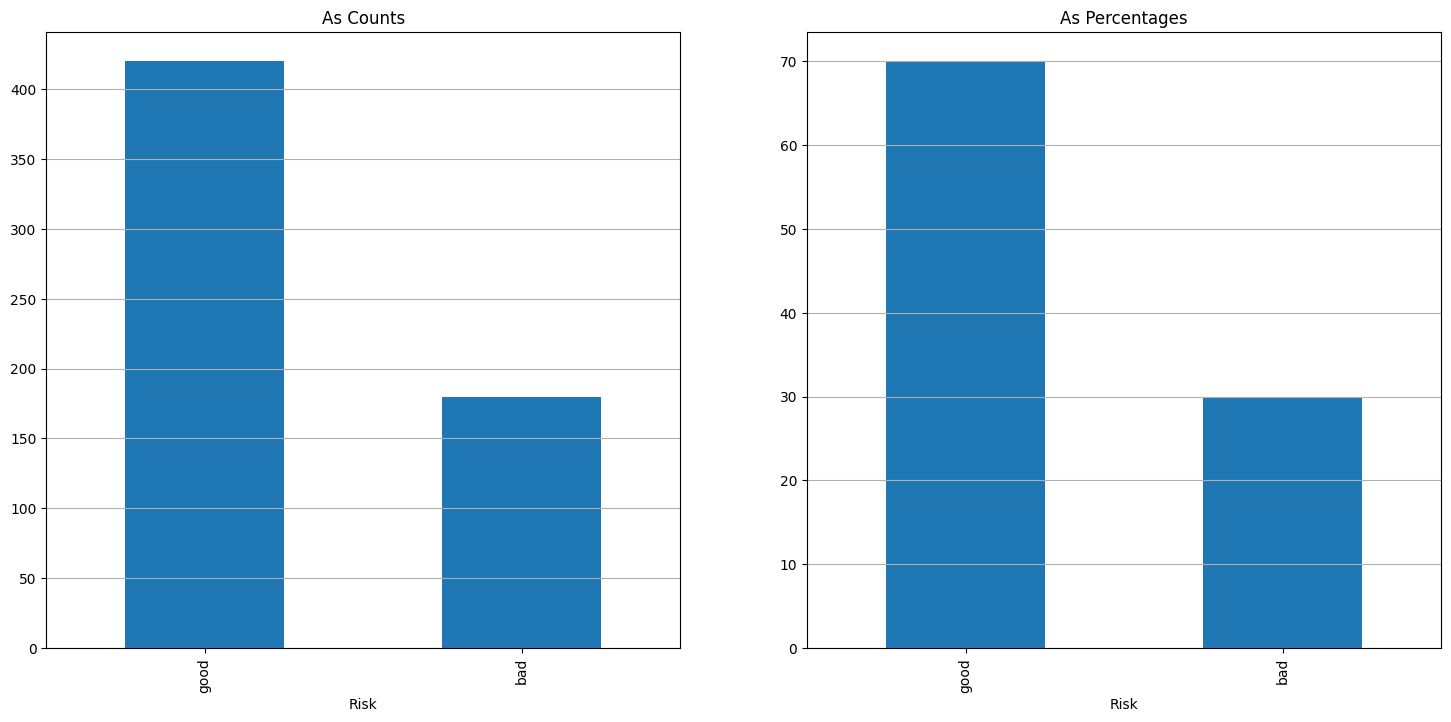

In [10]:
# looking for class imbalance problem
fig, ax = plt.subplots(1, 2, figsize=(18,8))
val_count = training['Risk'].value_counts()
val_count.plot(kind='bar', ax=ax[0])
ax[0].grid(axis='y')
ax[0].set_title('As Counts')

val_percentages = (val_count / len(training)) * 100
val_percentages.plot(kind='bar', ax=ax[1])
ax[1].grid(axis='y')
ax[1].set_title('As Percentages')

### There's a potential class imbalance problem. We'll try to use various techniques to address this issue later. 

In [11]:
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1)), p

Text(0.5, 1.0, 'Box Plot of Age by Risk')

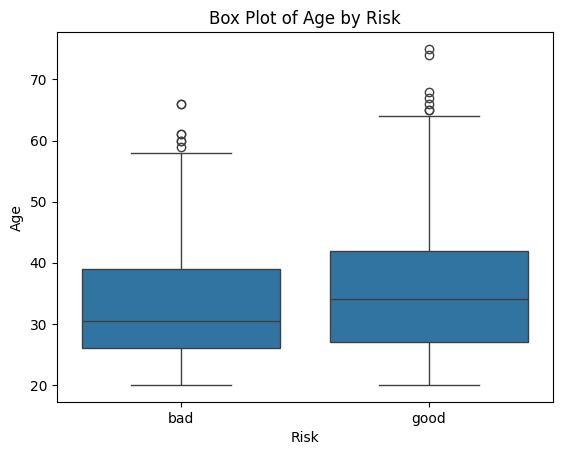

In [12]:
# age vs risk analysis
sns.boxplot(x='Risk', y='Age', data=training)
plt.title('Box Plot of Age by Risk')

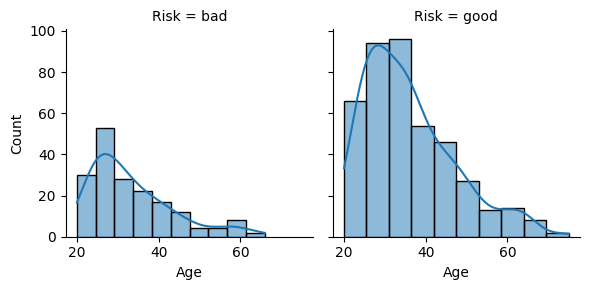

In [13]:
g = sns.FacetGrid(training, col='Risk')
g.map(sns.histplot, "Age", bins=10, kde=True)

### Observation: no distinct difference in the distributions. I feel like age doesn't add much as a decising factor in identifying loan defatults. Let's calculate the Cramer's V and test it.

In [14]:
cramers , p = cramers_v(pd.crosstab(training['Age'], training['Risk']))
print(f"Cramer's V is {cramers} and the p value from chi2 test is {p}")

Cramer's V is 0.26579861565083523 and the p value from chi2 test is 0.7691059856481655


### Cramer's V of 0.2 shows some association between age and risk but the p-value shows that there's a high likelihood the association is due to chance

Text(0.5, 0.98, 'Sex vs Risk Analysis')

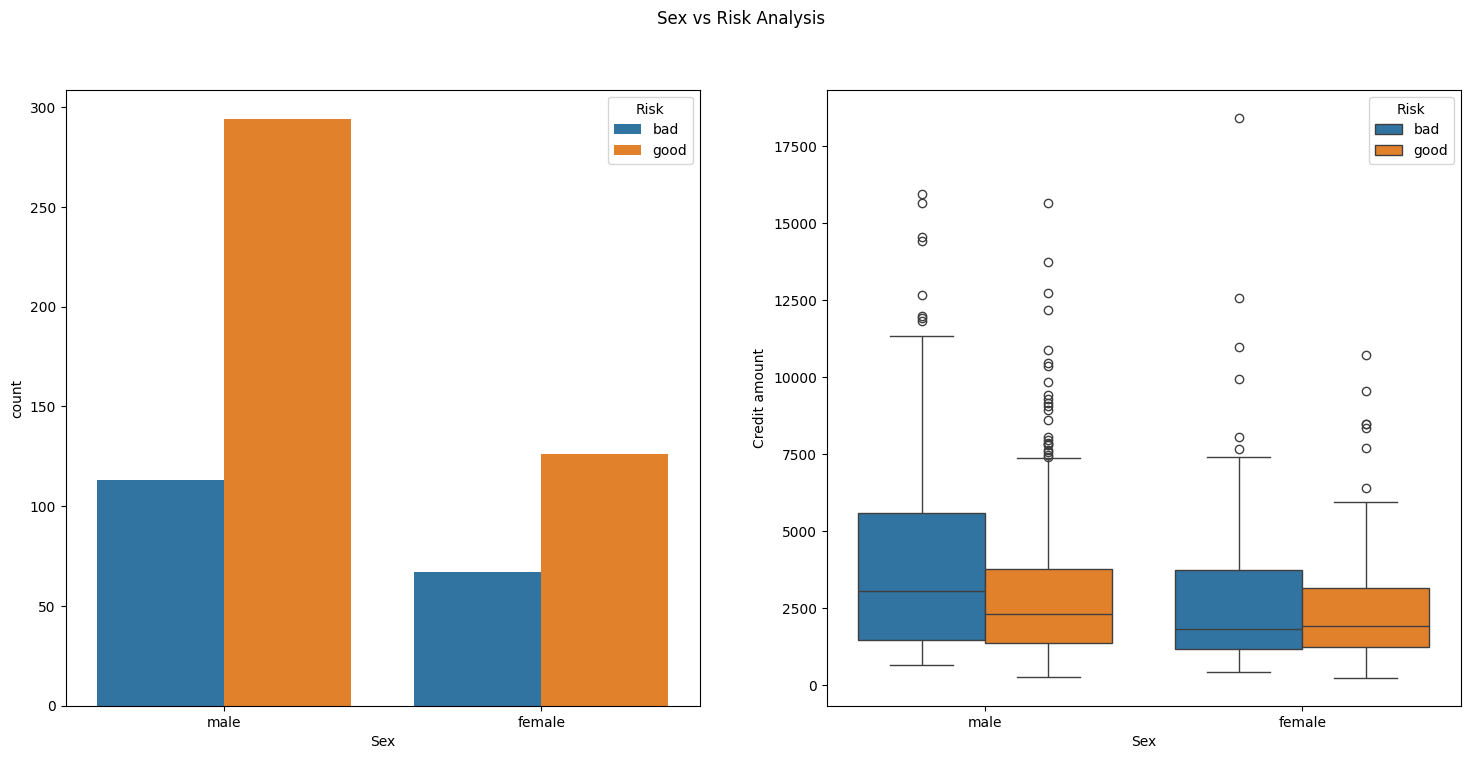

In [15]:
# sex vs risk analysis
fig, ax = plt.subplots(1, 2, figsize=(18,8))
sns.countplot(x='Sex', hue='Risk', data=training, ax=ax[0])
sns.boxplot(x='Sex', y='Credit amount', hue='Risk', data=training, ax=ax[1])
fig.suptitle('Sex vs Risk Analysis')

In [16]:
cramers , p = cramers_v(pd.crosstab(training['Sex'], training['Risk']))
print(f"Cramer's V is {cramers} and the p value from chi2 test is {p}")

Cramer's V is 0.06695961451366007 and the p value from chi2 test is 0.10097005597385134


### As thought, there's a weak association between sex and risk

<Axes: xlabel='Job', ylabel='Credit amount'>

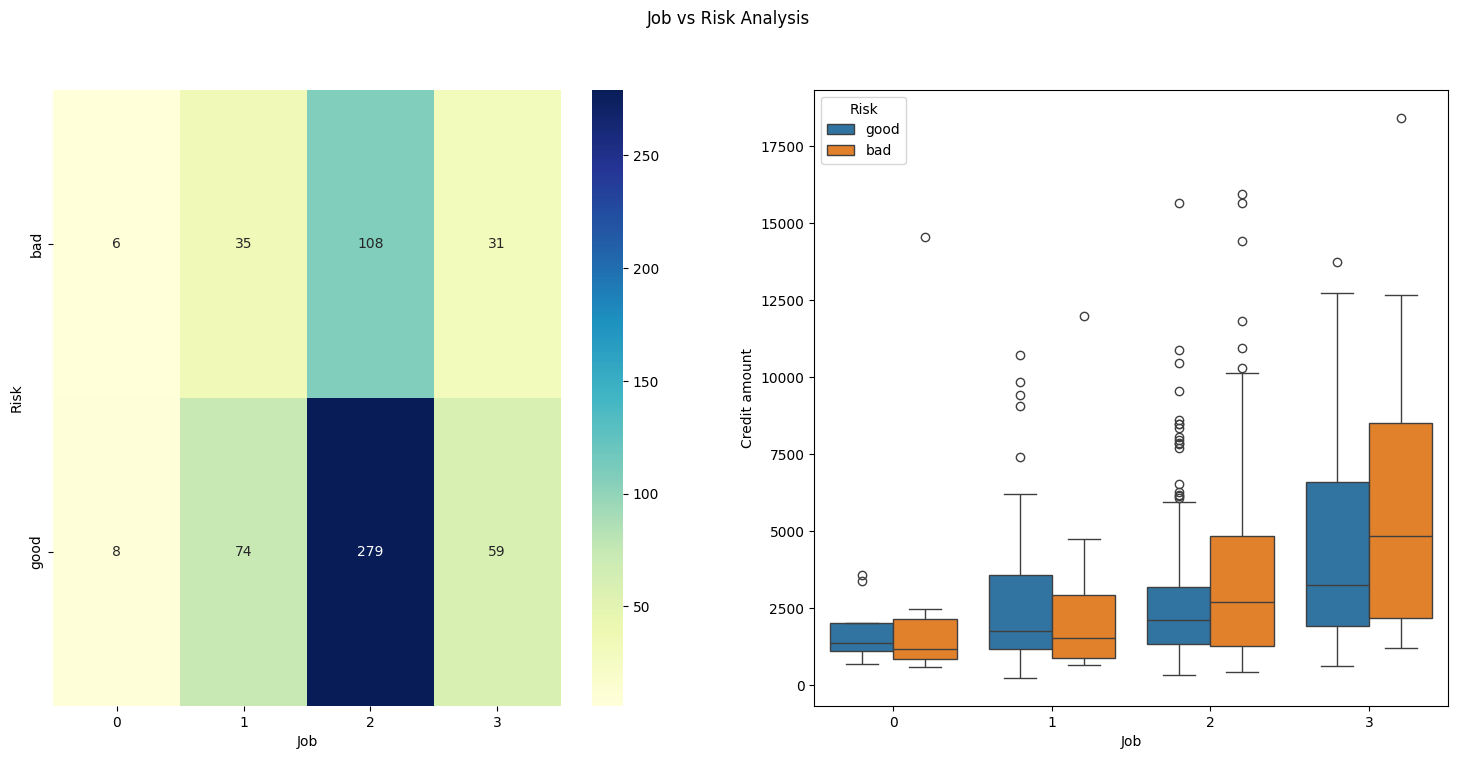

In [17]:
# job vs risk analysis
fig, ax = plt.subplots(1, 2, figsize=(18,8))
fig.suptitle('Job vs Risk Analysis')
cross_tab = pd.crosstab(training['Risk'], training['Job'])
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='d', ax=ax[0])
sns.boxplot(x='Job', y='Credit amount', hue='Risk', data=training, ax=ax[1])

In [18]:
cramers , p = cramers_v(pd.crosstab(training['Job'], training['Risk']))
print(f"Cramer's V is {cramers} and the p value from chi2 test is {p}")

Cramer's V is 0.07055749333154018 and the p value from chi2 test is 0.3936314013719444


<Axes: xlabel='Housing', ylabel='Credit amount'>

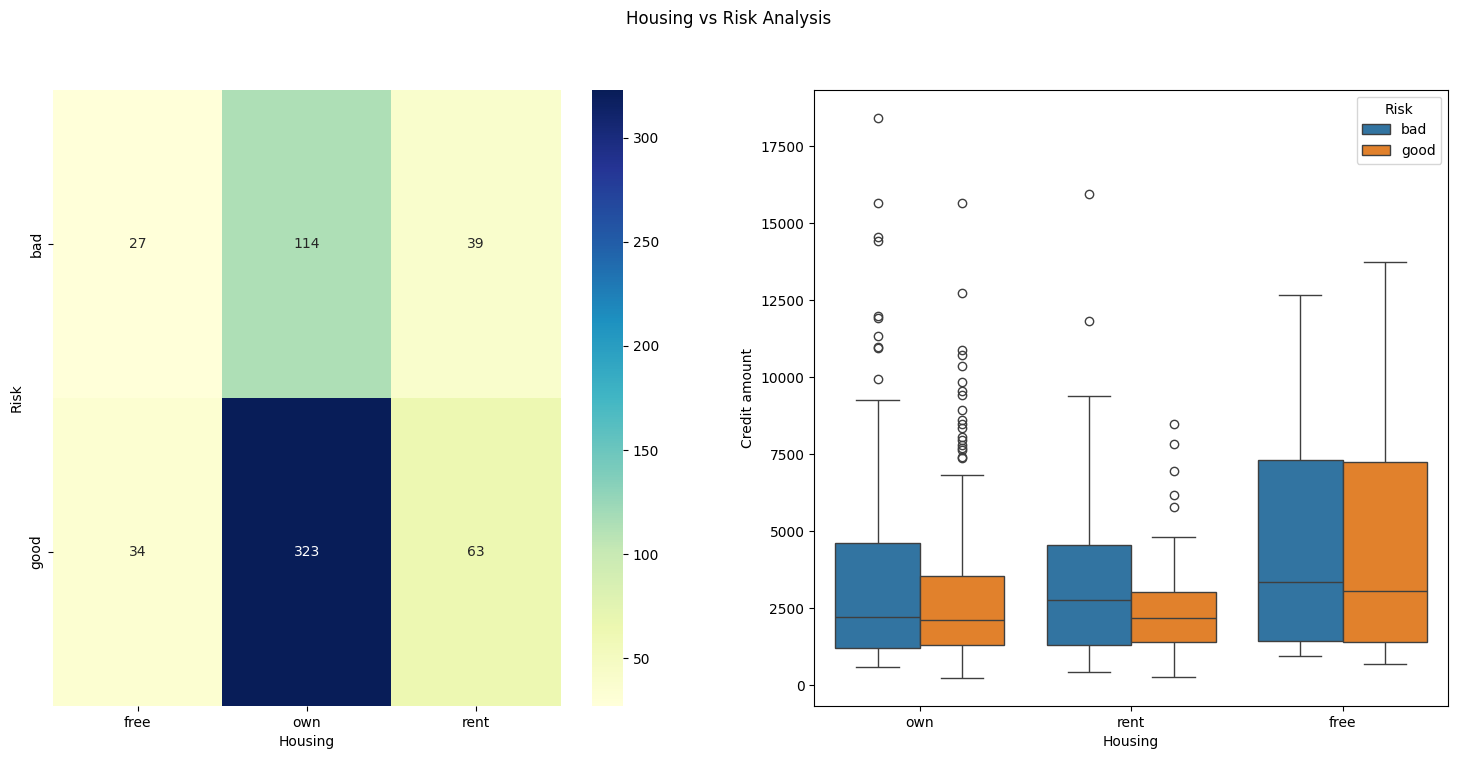

In [19]:
# housing vs risk analysis
fig, ax = plt.subplots(1, 2, figsize=(18,8))
fig.suptitle('Housing vs Risk Analysis')
cross_tab = pd.crosstab(training['Risk'], training['Housing'])
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='d', ax=ax[0])
sns.boxplot(x='Housing', y='Credit amount', hue='Risk', data=training, ax=ax[1])

In [20]:
cramers , p = cramers_v(pd.crosstab(training['Housing'], training['Risk']))
print(f"Cramer's V is {cramers} and the p value from chi2 test is {p}")

Cramer's V is 0.14369596466250048 and the p value from chi2 test is 0.0020405027037304815


### the combination of p-value and cramer's V shows that there's a high likelihood of association at a strenght of 14%

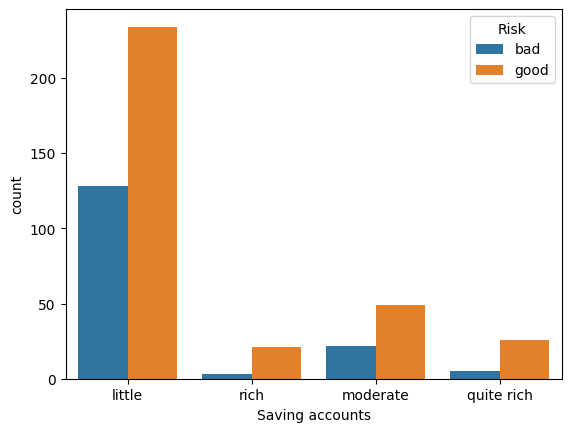

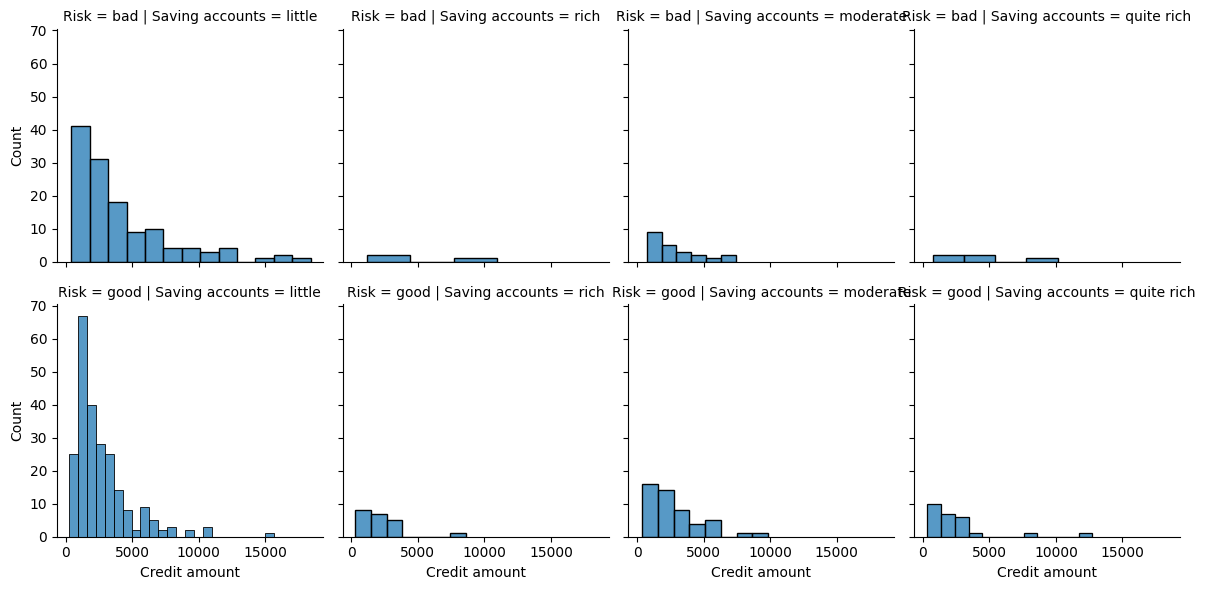

In [21]:
# Saving Accounts Type vs risk analysis
#fig, ax = plt.subplots(2, 1)
fig.suptitle('Saving Account Categories vs Risk Analysis')
sns.countplot(x='Saving accounts', hue='Risk', data=training)
#sns.boxplot(x='Housing', y='Credit amount', hue='Risk', data=training, ax=ax[1])
g = sns.FacetGrid(training, col='Saving accounts', row='Risk')
g.map(sns.histplot, 'Credit amount', ax=ax[1])

In [22]:
cramers , p = cramers_v(pd.crosstab(training['Saving accounts'], training['Risk']))
print(f"Cramer's V is {cramers} and the p value from chi2 test is {p}")

Cramer's V is 0.14027170374661346 and the p value from chi2 test is 0.022271037051741775


### Savings account category is associated with credit risk with high possibility with an association strength of 14%

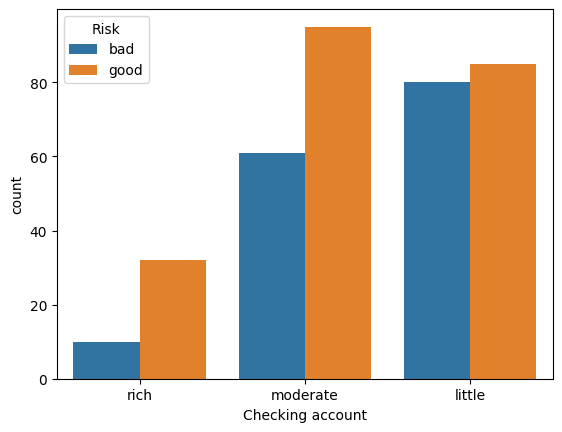

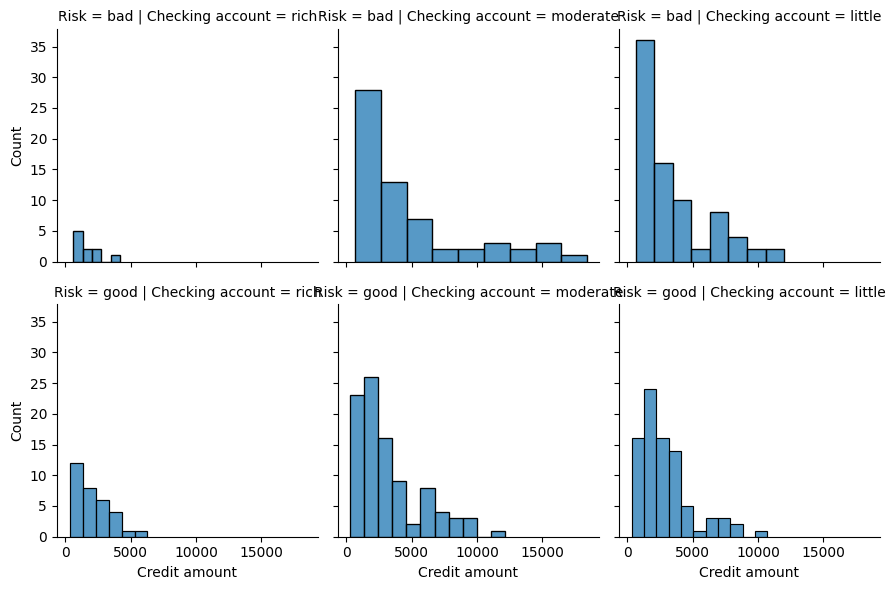

In [23]:
# Checking Accounts Type vs risk analysis
#fig, ax = plt.subplots(2, 1)
fig.suptitle('Checking Account Categories vs Risk Analysis')
sns.countplot(x='Checking account', hue='Risk', data=training)
#sns.boxplot(x='Housing', y='Credit amount', hue='Risk', data=training, ax=ax[1])
g = sns.FacetGrid(training, col='Checking account', row='Risk')
g.map(sns.histplot, 'Credit amount', ax=ax[1])

In [24]:
cramers , p = cramers_v(pd.crosstab(training['Checking account'], training['Risk']))
print(f"Cramer's V is {cramers} and the p value from chi2 test is {p}")

Cramer's V is 0.15825868200821872 and the p value from chi2 test is 0.01061152511815039


### Checkings account category is associated with credit risk with high possibility with an association strength of 16%

<Axes: xlabel='Purpose', ylabel='Credit amount'>

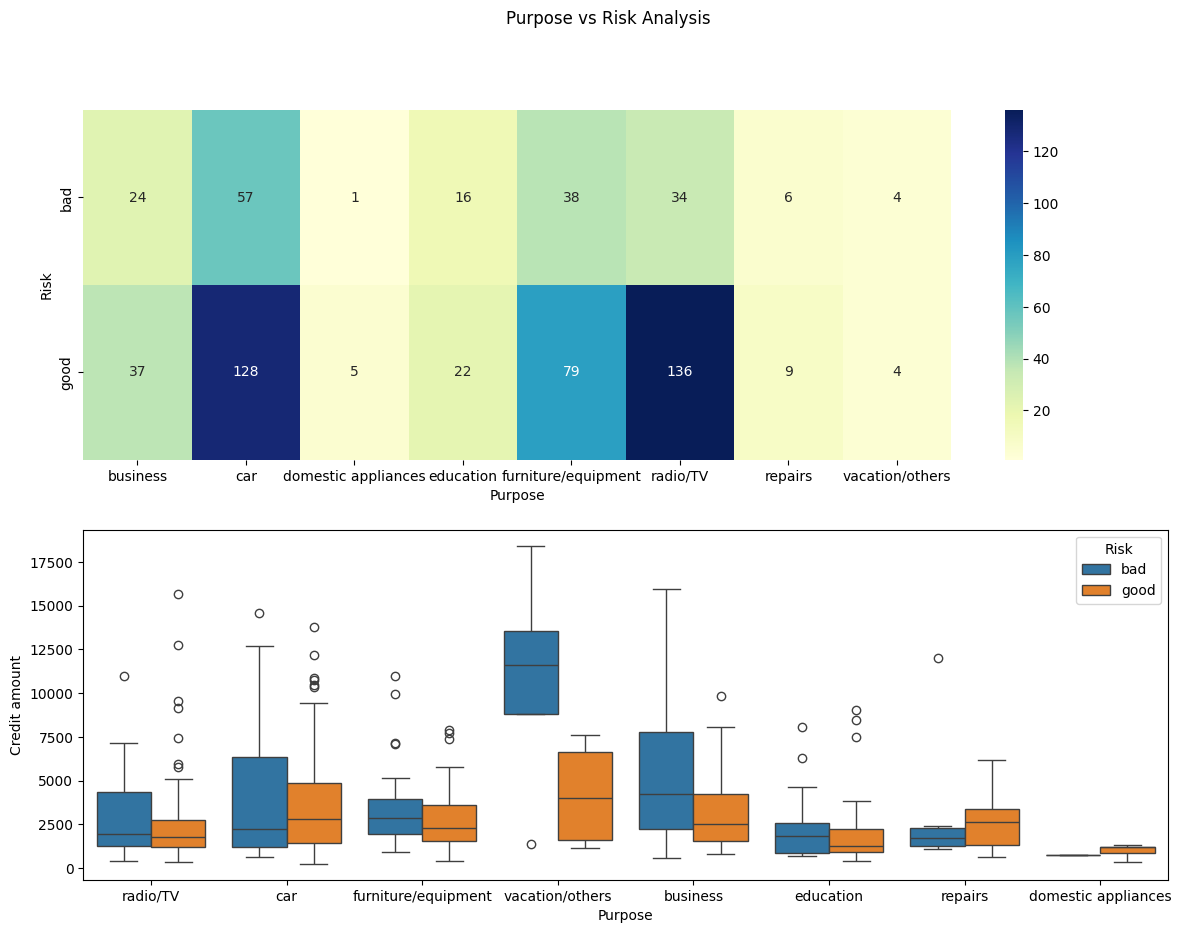

In [25]:
# purpose vs risk analysis
fig, ax = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Purpose vs Risk Analysis')
cross_tab = pd.crosstab(training['Risk'], training['Purpose'])
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='d', ax=ax[0])
sns.boxplot(x='Purpose', y='Credit amount', hue='Risk', data=training, ax=ax[1])

In [26]:
cramers , p = cramers_v(pd.crosstab(training['Purpose'], training['Risk']))
print(f"Cramer's V is {cramers} and the p value from chi2 test is {p}")

Cramer's V is 0.16547608628823032 and the p value from chi2 test is 0.021470131497105343


### A high possibility of association at a strength of about 16.5%

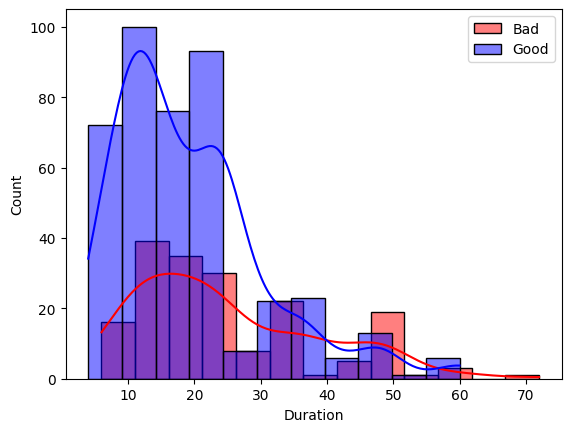

In [27]:
# duration vs risk analysis
sns.histplot(training[training['Risk'] == 'bad']['Duration'], color='red', label='Bad', kde=True, binwidth=5)
sns.histplot(training[training['Risk'] == 'good']['Duration'], color='blue', label='Good', kde=True, binwidth=5)
plt.legend()

### Performing t-test:
To check, if there is a statistically significant difference in loan duration between the two credit risk categories ('good' and 'bad')

In [28]:
good_risk_duration = training[training['Risk'] == 'good']['Duration']
bad_risk_duration = training[training['Risk'] == 'bad']['Duration']

In [29]:
good_risk_duration.shape, bad_risk_duration.shape

((420,), (180,))

In [30]:
# Check for normality (Shapiro-Wilk test)
print("Good risk normality p-value:", stats.shapiro(good_risk_duration)[1])
print("Bad risk normality p-value:", stats.shapiro(bad_risk_duration)[1])


Good risk normality p-value: 4.348242642113216e-17
Bad risk normality p-value: 3.941854842537396e-09


Since both the distribution violates the normality assumption, let's use a non-parametric test: Wilcoxon rank-sum test

In [31]:
_, p_value = stats.mannwhitneyu(good_risk_duration, bad_risk_duration)
print("P-Value:", p_value)

P-Value: 1.867028753190354e-06


Since the p-value is far less than 0.05, we reject the null hypothesis and conclude that there is a significant difference in loan duration between the 'good' and 'bad' risk groups. This implies that the distribution of loan durations is significantly different for these two categories of credit risk.

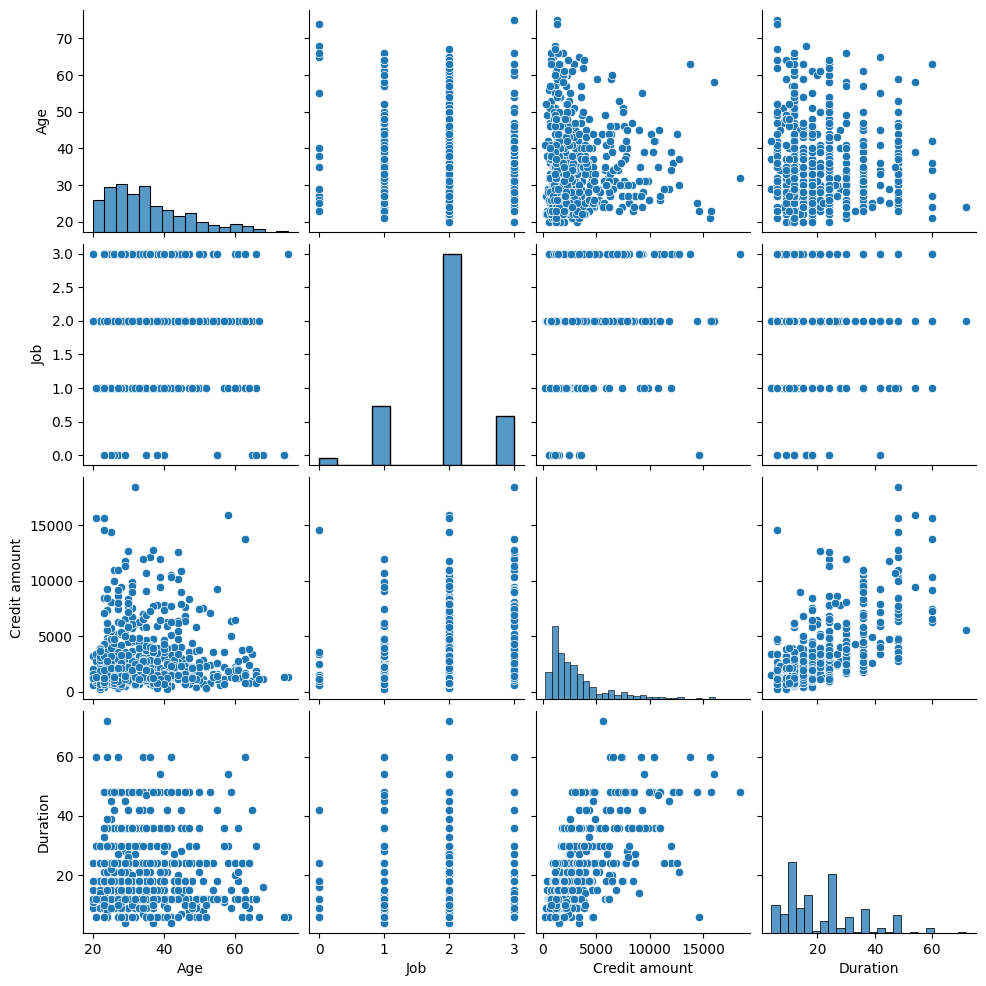

In [32]:
sns.pairplot(training)

### Feature Engineering

In [33]:
#splitting data into X and y
training_X = training.drop('Risk', axis=1)
training_y = training['Risk']
validation_X = validation.drop('Risk', axis=1)
validation_y = validation['Risk']
test_X = test.drop('Risk', axis=1)
test_y = test['Risk']

In [34]:
class CustomCategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.unique_values = {}
        
    def fit(self, X, y=None):
        for col in X.columns:
            self.unique_values[col] = X[col].dropna().unique()
        #print(self.unique_values)
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        
        for col in X_copy.columns:
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.unique_values[col] else col+'_unknown')
            
        X_encoded = pd.get_dummies(X_copy,columns=X_copy.columns, drop_first=True).astype(int)
        
        for col in X.columns:
            new_cols = {each: col+'_'+str(each) for each in self.unique_values[col]}
            
        X_encoded.rename(columns=new_cols, inplace=True)
        return X_encoded

In [35]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def fit(self, y):
        return self
    
    def transform(self, y):
        return y.map({'good':0, 'bad':1}).values

In [36]:
numerical_columns = ['Age','Credit amount', 'Duration']
cat_columns = list(set(training_X.columns) - set(numerical_columns))

In [37]:
numerical_columns

['Age', 'Credit amount', 'Duration']

In [38]:
cat_columns

['Sex', 'Saving accounts', 'Purpose', 'Housing', 'Job', 'Checking account']

In [39]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

In [41]:
cat_pipeline = Pipeline([
    ('encode', CustomCategoricalEncoder())
])

In [42]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numerical_columns),
    ('cat', cat_pipeline, cat_columns)
])

In [43]:
# tranforming y
target_encoder = TargetEncoder()
training_y_prepared = target_encoder.fit_transform(training_y)
validation_y_prepared = target_encoder.transform(validation_y)
test_y_prepared = target_encoder.transform(test_y)

In [44]:
# tranforming X
training_X_prepared = full_pipeline.fit_transform(training_X)
validation_X_prepared = full_pipeline.transform(validation_X)
test_X_prepared = full_pipeline.transform(test_X)

### Model Building

In [45]:
models = {
    'logistic_regression': LogisticRegression(),
    'KNN_classifier': KNeighborsClassifier(),
    'random_forst': RandomForestClassifier(),
    'SVM_linear': SVC(kernel='linear'),
    'XGboost': XGBClassifier(eval_metric='logloss'),
    'gaussian_NB': GaussianNB()
}

In [46]:
all_models_recall_score = {}
for name, model in models.items():
    recall = cross_val_score(model, training_X_prepared, training_y_prepared, cv=5, 
                             scoring=make_scorer(recall_score))
    all_models_recall_score[name] = recall
    

In [47]:
recall_df = pd.DataFrame(all_models_recall_score)
recall_df.describe()

logistic_regression  KNN_classifier  random_forst  SVM_linear  \
count             5.000000        5.000000      5.000000    5.000000   
mean              0.322222        0.261111      0.283333    0.272222   
std               0.046481        0.108653      0.102815    0.056928   
min               0.250000        0.111111      0.138889    0.222222   
25%               0.305556        0.194444      0.222222    0.222222   
50%               0.333333        0.277778      0.305556    0.250000   
75%               0.361111        0.361111      0.361111    0.333333   
max               0.361111        0.361111      0.388889    0.333333   

        XGboost  gaussian_NB  
count  5.000000     5.000000  
mean   0.388889     0.588889  
std    0.122663     0.187783  
min    0.194444     0.416667  
25%    0.388889     0.444444  
50%    0.388889     0.583333  
75%    0.444444     0.611111  
max    0.527778     0.888889

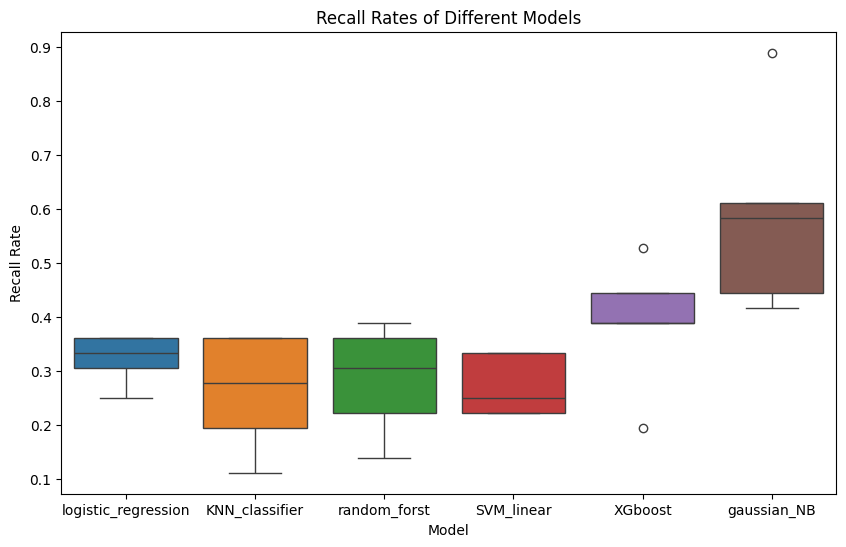

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=recall_df)
plt.title('Recall Rates of Different Models')
plt.ylabel('Recall Rate')
plt.xlabel('Model')
plt.show()

XGBoost and Gaussian_NB seems to work well with the dataset. Even though XGboost seems generalized to the dataset with low std when compared gaussian, naive bayes provides a recall at a minimum of 41.6% which seems better.

## Hyper parameter tuning of GaussianNB

In [49]:
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

In [50]:
gnb = GaussianNB()
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_search.fit(training_X_prepared, training_y_prepared)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='recall', verbose=1)

In [51]:
grid_search.best_estimator_

GaussianNB(var_smoothing=4.3287612810830526e-08)

In [52]:
best_gnb = grid_search.best_estimator_

In [53]:
# Validate on the validation data
y_val_pred = best_gnb.predict(validation_X_prepared)
recall_val = recall_score(validation_y_prepared, y_val_pred)
accuracy_val = accuracy_score(validation_y_prepared, y_val_pred)
f1_score_validation = f1_score(validation_y_prepared, y_val_pred)
precision_score_validation = precision_score(validation_y_prepared, y_val_pred)

print("Validation Recall: ", recall_val)
print("Validation Accuracy: ", accuracy_val)
print("Vaildation F1-score", f1_score_validation)
print("Vaildation Precision", precision_score_validation)
print("Classification Report: \n", classification_report(validation_y_prepared, y_val_pred))


Validation Recall:  0.5166666666666667
Validation Accuracy:  0.665
Vaildation F1-score 0.4806201550387597
Vaildation Precision 0.4492753623188406
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.73      0.75       140
           1       0.45      0.52      0.48        60

    accuracy                           0.67       200
   macro avg       0.61      0.62      0.62       200
weighted avg       0.68      0.67      0.67       200



In [54]:
# Evaluate on the test data
y_test_pred = best_gnb.predict(test_X_prepared)
recall_test = recall_score(test_y_prepared, y_test_pred)
accuracy_test = accuracy_score(test_y_prepared, y_test_pred)
f1_score_test = f1_score(test_y_prepared, y_test_pred)
precision_score_test = precision_score(test_y_prepared, y_test_pred)

print("Test Recall: ", recall_test)
print("Test Accuracy: ", accuracy_test)
print("Test F1-score", f1_score_test)
print("Test Precision", precision_score_test)
print("Classification Report: \n", classification_report(test_y_prepared, y_test_pred))

Test Recall:  0.5333333333333333
Test Accuracy:  0.655
Test F1-score 0.48120300751879697
Test Precision 0.4383561643835616
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.71      0.74       140
           1       0.44      0.53      0.48        60

    accuracy                           0.66       200
   macro avg       0.61      0.62      0.61       200
weighted avg       0.68      0.66      0.66       200



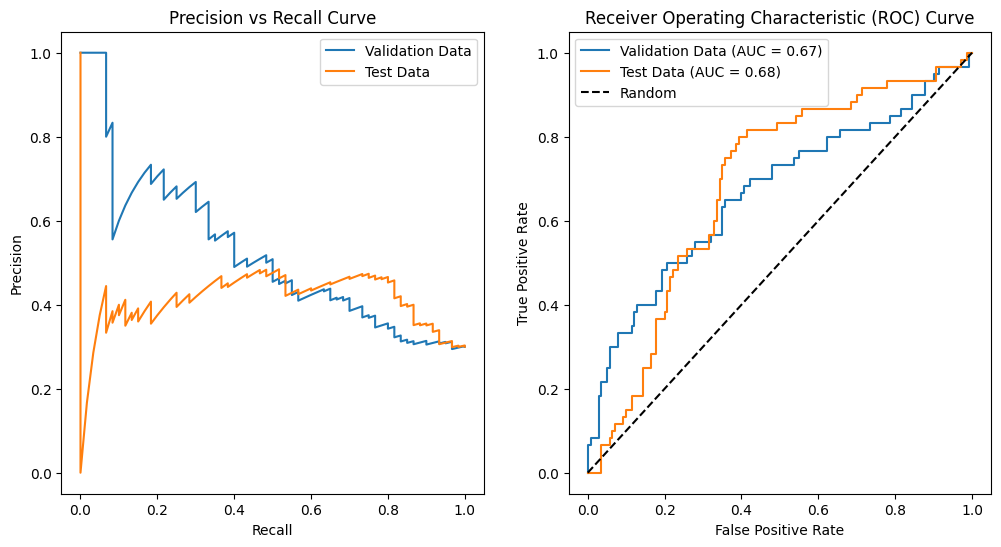

In [55]:
validation_y_predicted = best_gnb.predict_proba(validation_X_prepared)[:, 1]
precision_val, recall_val, _ = precision_recall_curve(validation_y_prepared, validation_y_predicted)
fpr_val, tpr_val, _ = roc_curve(validation_y_prepared, validation_y_predicted)
roc_auc_val = auc(fpr_val, tpr_val)

test_y_predicted = best_gnb.predict_proba(test_X_prepared)[:, 1]
precision_test, recall_test, _ = precision_recall_curve(test_y_prepared, test_y_predicted)
fpr_test, tpr_test, _ = roc_curve(test_y_prepared, test_y_predicted)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(recall_val, precision_val, label='Validation Data')
plt.plot(recall_test, precision_test, label='Test Data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall Curve')
plt.legend()

# Plot ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr_val, tpr_val, label=f'Validation Data (AUC = {roc_auc_val:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test Data (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()


## Since, there's a potential class-imbalance problem, let's try using SMOTE(Synthetic Minority Over-Sampling Technique)

In [56]:
from imblearn.over_sampling import SMOTE

In [57]:
smote = SMOTE(random_state=42)
training_X_resampled, training_y_resampled = smote.fit_resample(training_X_prepared, training_y_prepared)
print(len(training_X_prepared), sum(training_y_prepared))
print(len(training_X_resampled), sum(training_y_resampled))

600 180
840 420


In [58]:
all_models_recall_score_smote = {}
for name, model in models.items():
    recall = cross_val_score(model, training_X_resampled, training_y_resampled, cv=10, 
                             scoring=make_scorer(recall_score))
    all_models_recall_score_smote[name] = recall
    

In [59]:
recall_df = pd.DataFrame(all_models_recall_score_smote)
recall_df.describe()

logistic_regression  KNN_classifier  random_forst  SVM_linear  \
count            10.000000       10.000000     10.000000   10.000000   
mean              0.747619        0.885714      0.788095    0.766667   
std               0.077923        0.073429      0.238743    0.069007   
min               0.642857        0.761905      0.452381    0.642857   
25%               0.690476        0.839286      0.541667    0.714286   
50%               0.750000        0.904762      0.916667    0.809524   
75%               0.785714        0.952381      0.994048    0.809524   
max               0.880952        0.952381      1.000000    0.833333   

         XGboost  gaussian_NB  
count  10.000000    10.000000  
mean    0.804762     0.897619  
std     0.215254     0.046345  
min     0.476190     0.833333  
25%     0.613095     0.880952  
50%     0.916667     0.892857  
75%     0.976190     0.922619  
max     1.000000     0.976190

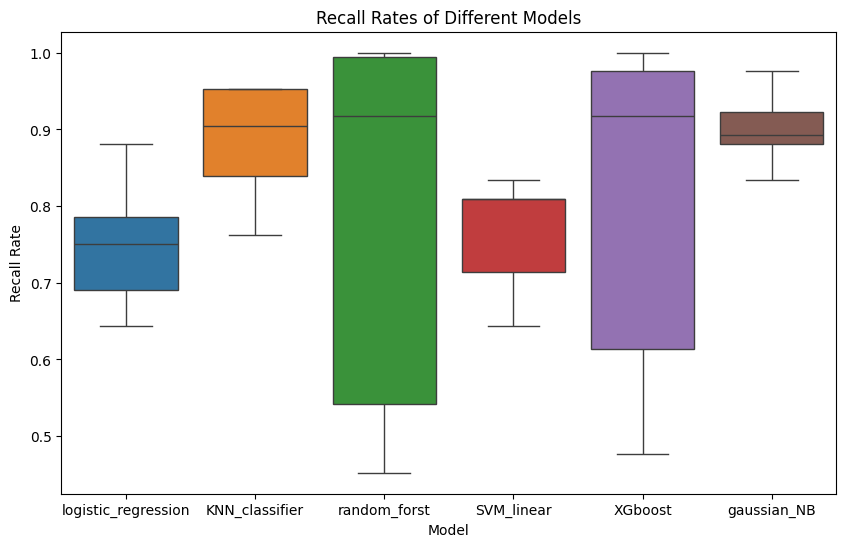

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=recall_df)
plt.title('Recall Rates of Different Models')
plt.ylabel('Recall Rate')
plt.xlabel('Model')
plt.show()

In [61]:
# choosing the best model
gnb = GaussianNB()
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_search.fit(training_X_resampled, training_y_resampled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='recall', verbose=1)

In [62]:
best_gnb_smote = grid_search.best_estimator_

In [63]:
# Validate on the validation data
y_val_pred = best_gnb_smote.predict(validation_X_prepared)
recall_val = recall_score(validation_y_prepared, y_val_pred)
accuracy_val = accuracy_score(validation_y_prepared, y_val_pred)
f1_score_validation = f1_score(validation_y_prepared, y_val_pred)
precision_score_validation = precision_score(validation_y_prepared, y_val_pred)

print("Validation Recall: ", recall_val)
print("Validation Accuracy: ", accuracy_val)
print("Vaildation F1-score", f1_score_validation)
print("Vaildation Precision", precision_score_validation)
print("Classification Report: \n", classification_report(validation_y_prepared, y_val_pred))


Validation Recall:  0.7666666666666667
Validation Accuracy:  0.505
Vaildation F1-score 0.4816753926701571
Vaildation Precision 0.3511450381679389
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.39      0.53       140
           1       0.35      0.77      0.48        60

    accuracy                           0.51       200
   macro avg       0.57      0.58      0.50       200
weighted avg       0.66      0.51      0.51       200



In [64]:
# Evaluate on the test data
y_test_pred = best_gnb_smote.predict(test_X_prepared)
recall_test = recall_score(test_y_prepared, y_test_pred)
accuracy_test = accuracy_score(test_y_prepared, y_test_pred)
f1_score_test = f1_score(test_y_prepared, y_test_pred)
precision_score_test = precision_score(test_y_prepared, y_test_pred)

print("Test Recall: ", recall_test)
print("Test Accuracy: ", accuracy_test)
print("Test F1-score", f1_score_test)
print("Test Precision", precision_score_test)
print("Classification Report: \n", classification_report(test_y_prepared, y_test_pred))

Test Recall:  0.8333333333333334
Test Accuracy:  0.565
Test F1-score 0.53475935828877
Test Precision 0.3937007874015748
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.45      0.59       140
           1       0.39      0.83      0.53        60

    accuracy                           0.56       200
   macro avg       0.63      0.64      0.56       200
weighted avg       0.72      0.56      0.57       200



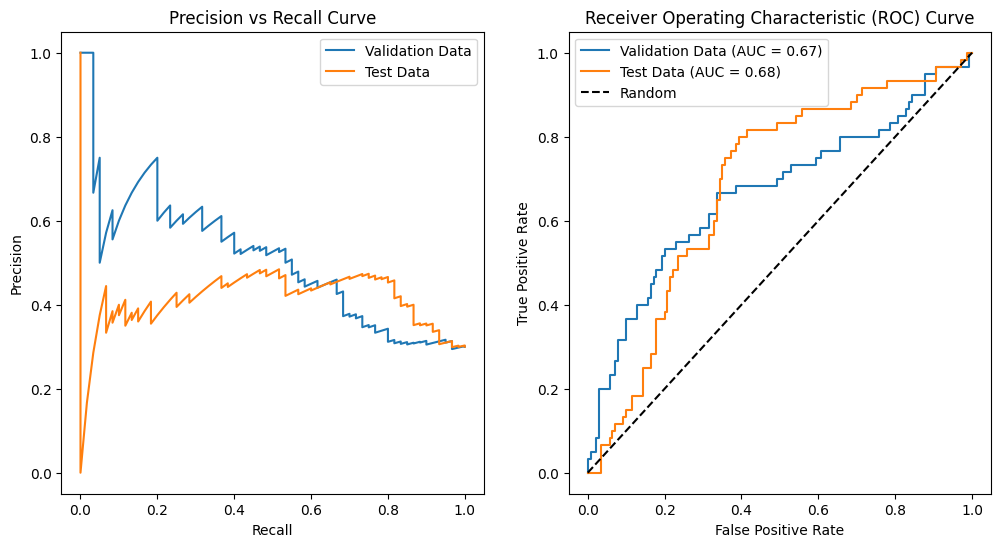

In [65]:
validation_y_predicted = best_gnb_smote.predict_proba(validation_X_prepared)[:, 1]
precision_val, recall_val, _ = precision_recall_curve(validation_y_prepared, validation_y_predicted)
fpr_val, tpr_val, _ = roc_curve(validation_y_prepared, validation_y_predicted)
roc_auc_val = auc(fpr_val, tpr_val)

test_y_predicted = best_gnb.predict_proba(test_X_prepared)[:, 1]
precision_test, recall_test, _ = precision_recall_curve(test_y_prepared, test_y_predicted)
fpr_test, tpr_test, _ = roc_curve(test_y_prepared, test_y_predicted)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(recall_val, precision_val, label='Validation Data')
plt.plot(recall_test, precision_test, label='Test Data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall Curve')
plt.legend()

# Plot ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr_val, tpr_val, label=f'Validation Data (AUC = {roc_auc_val:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test Data (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()


## Since, there's a potential class-imbalance problem, let's try using some under-sampling techniques

In [66]:
from imblearn.under_sampling import RandomUnderSampler

In [67]:
rus = RandomUnderSampler(random_state=42)
training_X_resampled, training_y_resampled = rus.fit_resample(training_X_prepared, training_y_prepared)
print(len(training_X_prepared), sum(training_y_prepared))
print(len(training_X_resampled), sum(training_y_resampled))

600 180
360 180


       logistic_regression  KNN_classifier  random_forst  SVM_linear  \
count            10.000000       10.000000     10.000000   10.000000   
mean              0.672222        0.566667      0.655556    0.694444   
std               0.088618        0.104100      0.113553    0.095330   
min               0.555556        0.388889      0.444444    0.555556   
25%               0.625000        0.513889      0.625000    0.611111   
50%               0.666667        0.555556      0.666667    0.694444   
75%               0.666667        0.652778      0.722222    0.777778   
max               0.888889        0.722222      0.833333    0.833333   

         XGboost  gaussian_NB  
count  10.000000    10.000000  
mean    0.605556     0.733333  
std     0.146869     0.107344  
min     0.388889     0.555556  
25%     0.555556     0.722222  
50%     0.555556     0.722222  
75%     0.736111     0.763889  
max     0.833333     0.944444  


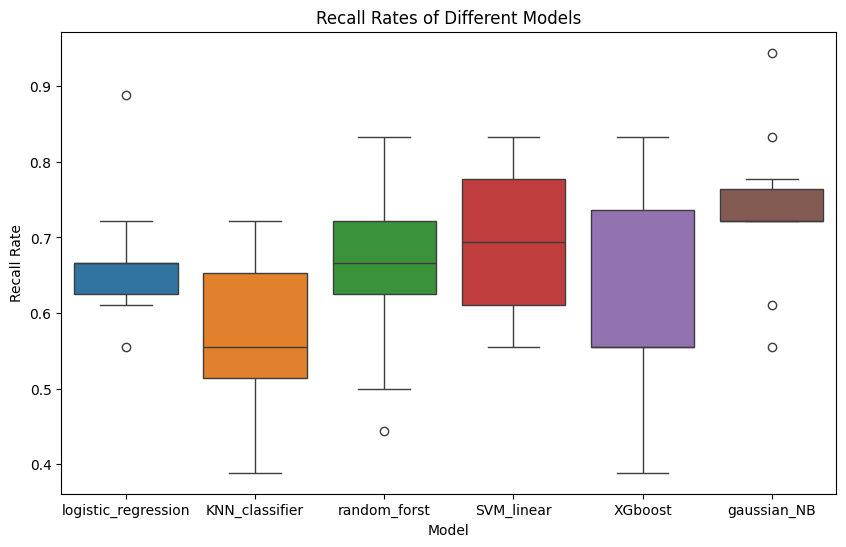

In [68]:
all_models_recall_score_rus = {}
for name, model in models.items():
    recall = cross_val_score(model, training_X_resampled, training_y_resampled, cv=10, 
                             scoring=make_scorer(recall_score))
    all_models_recall_score_rus[name] = recall

    
recall_df = pd.DataFrame(all_models_recall_score_rus)
print(recall_df.describe())

plt.figure(figsize=(10, 6))
sns.boxplot(data=recall_df)
plt.title('Recall Rates of Different Models')
plt.ylabel('Recall Rate')
plt.xlabel('Model')
plt.show()

In [69]:
# choosing the best model
gnb = GaussianNB()
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_search.fit(training_X_resampled, training_y_resampled)

best_gnb_rus = grid_search.best_estimator_

# Validate on the validation data
y_val_pred = best_gnb_rus.predict(validation_X_prepared)
recall_val = recall_score(validation_y_prepared, y_val_pred)
accuracy_val = accuracy_score(validation_y_prepared, y_val_pred)
f1_score_validation = f1_score(validation_y_prepared, y_val_pred)
precision_score_validation = precision_score(validation_y_prepared, y_val_pred)

print("Validation Recall: ", recall_val)
print("Validation Accuracy: ", accuracy_val)
print("Vaildation F1-score", f1_score_validation)
print("Vaildation Precision", precision_score_validation)
print("Classification Report: \n", classification_report(validation_y_prepared, y_val_pred))

# Evaluate on the test data
y_test_pred = best_gnb_rus.predict(test_X_prepared)
recall_test = recall_score(test_y_prepared, y_test_pred)
accuracy_test = accuracy_score(test_y_prepared, y_test_pred)
f1_score_test = f1_score(test_y_prepared, y_test_pred)
precision_score_test = precision_score(test_y_prepared, y_test_pred)

print("Test Recall: ", recall_test)
print("Test Accuracy: ", accuracy_test)
print("Test F1-score", f1_score_test)
print("Test Precision", precision_score_test)
print("Classification Report: \n", classification_report(test_y_prepared, y_test_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Validation Recall:  0.6333333333333333
Validation Accuracy:  0.61
Vaildation F1-score 0.49350649350649345
Vaildation Precision 0.40425531914893614
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.60      0.68       140
           1       0.40      0.63      0.49        60

    accuracy                           0.61       200
   macro avg       0.60      0.62      0.59       200
weighted avg       0.68      0.61      0.63       200

Test Recall:  0.75
Test Accuracy:  0.675
Test F1-score 0.5806451612903226
Test Precision 0.47368421052631576
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.64      0.73       140
           1       0.47      0.75      0.58        60

    accuracy                           0.68       200
   macro avg       0.67      0.70      0.66       200
weighted avg       0.74      0.6

## Anomaly detection using Isoforest

In [70]:
from sklearn.ensemble import IsolationForest

In [71]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.2, random_state=42)
iso_forest.fit(training_X_resampled)

IsolationForest(contamination=0.2, random_state=42)

In [72]:
y_pred_validation = iso_forest.predict(validation_X_prepared)

In [73]:
y_pred_validation = np.where(y_pred_validation == 1, 0, 1)

In [74]:
print(classification_report(validation_y_prepared, y_pred_validation))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       140
           1       0.40      0.33      0.36        60

    accuracy                           0.65       200
   macro avg       0.57      0.56      0.56       200
weighted avg       0.63      0.65      0.64       200



In [75]:
y_pred_test = iso_forest.predict(test_X_prepared)
y_pred_test = np.where(y_pred_test == 1, 0, 1)
print(classification_report(test_y_prepared, y_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       140
           1       0.26      0.20      0.22        60

    accuracy                           0.58       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.56      0.58      0.57       200

